In [2]:

import os
import numpy as np
import pandas as pd
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')
from pathlib import Path

In [3]:
# %% Imports
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path
from tqdm import tqdm

# %% Función para análisis de escala de grises
def analyze_grayscale_distribution(folder_path, sample_size=500):
    """
    Analiza la distribución de intensidades en imágenes de escala de grises
    """
    # Buscar imágenes
    extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.tiff')
    image_paths = []
    
    for ext in extensions:
        image_paths.extend(Path(folder_path).rglob(f'*{ext}'))
        image_paths.extend(Path(folder_path).rglob(f'*{ext.upper()}'))
    
    # Muestrear si hay muchas imágenes
    if len(image_paths) > sample_size:
        image_paths = np.random.choice(image_paths, sample_size, replace=False)
    
    print(f"Analizando {len(image_paths)} imágenes en escala de grises...")
    
    all_pixels = []
    image_stats = []
    
    for img_path in tqdm(image_paths):
        try:
            # Cargar como escala de grises
            img = Image.open(img_path).convert('L')
            img_array = np.array(img)
            
            # Muestrear píxeles para eficiencia
            step = max(1, img_array.shape[0] // 50)  # Cada 50 píxeles aprox
            pixels = img_array[::step, ::step].flatten()
            
            all_pixels.extend(pixels)
            
            # Estadísticas por imagen
            image_stats.append({
                'mean': img_array.mean(),
                'std': img_array.std(),
                'median': np.median(img_array),
                'min': img_array.min(),
                'max': img_array.max(),
                'q25': np.percentile(img_array, 25),
                'q75': np.percentile(img_array, 75)
            })
            
        except Exception as e:
            continue
    
    return np.array(all_pixels), image_stats


In [4]:
PROJECT_ROOT = (Path.cwd() / ".." / "..").resolve()
DATA_PATH = PROJECT_ROOT / "datasets"
ORIGINAL_DATA = DATA_PATH / "raw" / "images"
PROCESSED_DATA = DATA_PATH / "processed" / "images"

In [5]:
def analyze_grayscale_distribution(folder_path, sample_size=500):
    """
    Analiza la distribución de intensidades en imágenes de escala de grises
    """
    # Buscar imágenes
    extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.tiff')
    image_paths = []
    
    for ext in extensions:
        image_paths.extend(Path(folder_path).rglob(f'*{ext}'))
        image_paths.extend(Path(folder_path).rglob(f'*{ext.upper()}'))
    
    # Muestrear si hay muchas imágenes
    if len(image_paths) > sample_size:
        image_paths = np.random.choice(image_paths, sample_size, replace=False)
    
    print(f"Analizando {len(image_paths)} imágenes en escala de grises...")
    
    all_pixels = []
    image_stats = []
    
    for img_path in tqdm(image_paths):
        try:
            # Cargar como escala de grises
            img = Image.open(img_path).convert('L')
            img_array = np.array(img)
            
            # Muestrear píxeles para eficiencia
            step = max(1, img_array.shape[0] // 50)  # Cada 50 píxeles aprox
            pixels = img_array[::step, ::step].flatten()
            
            all_pixels.extend(pixels)
            
            # Estadísticas por imagen
            image_stats.append({
                'mean': img_array.mean(),
                'std': img_array.std(),
                'median': np.median(img_array),
                'min': img_array.min(),
                'max': img_array.max(),
                'q25': np.percentile(img_array, 25),
                'q75': np.percentile(img_array, 75)
            })
            
        except Exception as e:
            continue
    
    return np.array(all_pixels), image_stats

In [6]:
train_pixels, train_stats = analyze_grayscale_distribution(PROCESSED_DATA / "train" / "images")


Analizando 500 imágenes en escala de grises...


100%|██████████| 500/500 [00:06<00:00, 82.68it/s]


In [7]:
val_path = PROCESSED_DATA / "val" / "images"
if val_path.exists():
    val_pixels, val_stats = analyze_grayscale_distribution(val_path)
else:
    val_pixels = val_stats = None
    print("No se encontró carpeta de validación")

Analizando 164 imágenes en escala de grises...


100%|██████████| 164/164 [00:02<00:00, 79.81it/s]


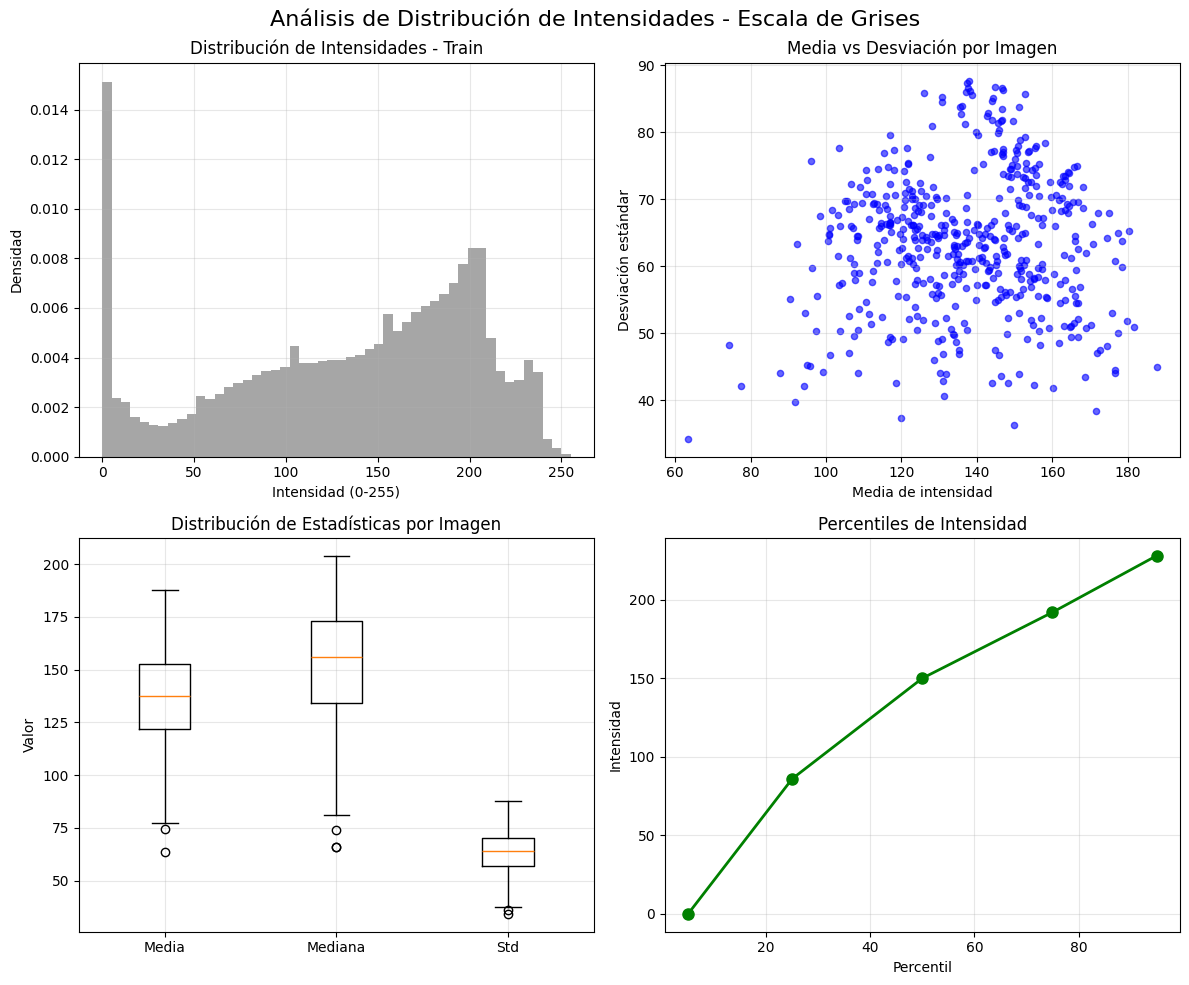

In [10]:
# %% Visualización
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Análisis de Distribución de Intensidades - Escala de Grises', fontsize=16)

# 1. Histograma de intensidades
axes[0,0].hist(train_pixels, bins=50, alpha=0.7, color='gray', density=True)
axes[0,0].set_title('Distribución de Intensidades - Train')
axes[0,0].set_xlabel('Intensidad (0-255)')
axes[0,0].set_ylabel('Densidad')
axes[0,0].grid(True, alpha=0.3)
# 2. Estadísticas por imagen
train_means = [stat['mean'] for stat in train_stats]
train_stds = [stat['std'] for stat in train_stats]

axes[0,1].scatter(train_means, train_stds, alpha=0.6, s=20, color='blue')
axes[0,1].set_title('Media vs Desviación por Imagen')
axes[0,1].set_xlabel('Media de intensidad')
axes[0,1].set_ylabel('Desviación estándar')
axes[0,1].grid(True, alpha=0.3)

# 3. Box plot de estadísticas
stats_data = [
    [stat['mean'] for stat in train_stats],
    [stat['median'] for stat in train_stats],
    [stat['std'] for stat in train_stats]
]

axes[1,0].boxplot(stats_data, labels=['Media', 'Mediana', 'Std'])
axes[1,0].set_title('Distribución de Estadísticas por Imagen')
axes[1,0].set_ylabel('Valor')
axes[1,0].grid(True, alpha=0.3)

# 4. Percentiles de intensidad
percentiles = [5, 25, 50, 75, 95]
perc_values = np.percentile(train_pixels, percentiles)

axes[1,1].plot(percentiles, perc_values, 'o-', linewidth=2, markersize=8, color='green')
axes[1,1].set_title('Percentiles de Intensidad')
axes[1,1].set_xlabel('Percentil')
axes[1,1].set_ylabel('Intensidad')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



Porcentaje de píxeles en valor 0: 5.69%
Estadísticas SIN píxeles 0:
  Media: 142.9
  Mediana: 156.0
  Rango: 1 - 255


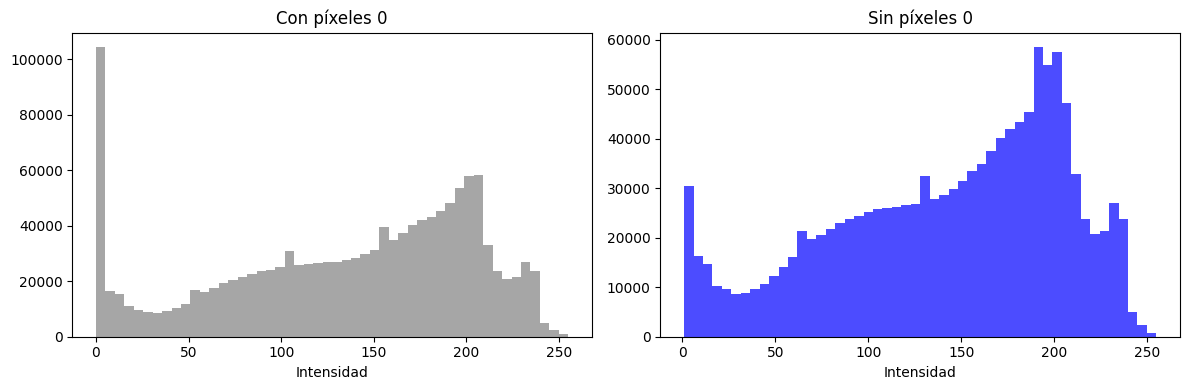

In [12]:
# %% Diagnóstico del spike en 0
zero_percentage = (train_pixels == 0).sum() / len(train_pixels) * 100
print(f"Porcentaje de píxeles en valor 0: {zero_percentage:.2f}%")

# Ver distribución sin el valor 0
non_zero_pixels = train_pixels[train_pixels > 0]
print(f"Estadísticas SIN píxeles 0:")
print(f"  Media: {non_zero_pixels.mean():.1f}")
print(f"  Mediana: {np.median(non_zero_pixels):.1f}")
print(f"  Rango: {non_zero_pixels.min()} - {non_zero_pixels.max()}")

# Gráfico comparativo
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.hist(train_pixels, bins=50, alpha=0.7, color='gray')
ax1.set_title('Con píxeles 0')
ax1.set_xlabel('Intensidad')

ax2.hist(non_zero_pixels, bins=50, alpha=0.7, color='blue')
ax2.set_title('Sin píxeles 0')
ax2.set_xlabel('Intensidad')

plt.tight_layout()
plt.show()